# PERSONALIZED CANCER DIAGNOSIS 

## Description 
data source : https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 

Data: Memorial Sloan kettering Cancer Center (MSKCC)

Context Source : https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problems: Classify the given genetic variations/mutations based on evidence from text-based clinical literature

## Some Useful-links:
1.  https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25

2. https://www.youtube.com/watch?v=qxXRKVompI8

3. https://www.youtube.com/watch?v=7W17xH62MVA

#### Mutation vs Variations

**Mutation**: It is the suddent change at DNA level that affects indivisuals

**Variations**: It is the difference in the properties of indivisual or group of indivisual of same species

# Data

## Data-Overview:
1. Sources: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

We have two files: One contains the information about the genetic mutations and the other contains the clinical evidence(text) that human expert use to classify the genetic muations

Both these data files have a common column called ID 

Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>



### Examples data points

**training_variants**:


---

ID,Gene,Variation,Class

0,FAM58A,Truncating Mutations,1

1,CBL,W802*,2

2,CBL,Q249E,2

3,CBL,N454D,3
....

**training_text(clinical literature)**


---
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome. ...



## Mapping the real world problems to the ML problems:
Since there are nine classes that a genetic mutation can be classified as ==> So it a multiclass classification problems 

### Performance Matrics:
*   multi-class log-loss
*   Confusion-matrix



# Exploratory Data Analysis

In [3]:
import time
import sys
import six
sys.modules['sklearn.externals.six'] = six # for compatibility of python 2 and python 3. it provides utility version for smoothing
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, normalized_mutual_info_score

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier, LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter, defaultdict
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier


## Reading data as variant_Data and text_Data

In [4]:
# Reading the variant data
variant_data = pd.read_csv('/content/drive/MyDrive/training_cancerData/training_variants/training_variants')

In [5]:
print("number of data points is: ", variant_data.shape[0])
print("number of features are : ", variant_data.shape[1])
print("Features name are : ", variant_data.columns.values)
variant_data.head()

number of data points is:  3321
number of features are :  4
Features name are :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


__Training_Variants are a comma seperated files containing the description of the genetic mutation used for training

*   ID: ID of row used to link the mutation of clinical data
*   Gene: gene's name where genetic mutation is located
*   Variations: change in amino-acid for this mutation
*   Class: there are 9 classes genetic  mutation has been classified into





In [6]:
# Reading the text files
text_data = pd.read_csv('/content/drive/MyDrive/training_cancerData/training_text/training_text', sep="\|\|",
                    engine="python", names=["ID","TEXT"], skiprows=1)

In [7]:
print("number of data points is: ", text_data.shape[0])
print("number of features is : ", text_data.shape[1])
print("feature name are: ", text_data.columns.values)
text_data.head()

number of data points is:  3321
number of features is :  2
feature name are:  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Preprocessing of Text:

In [8]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def nlp_preprocessing(text, index, column):
    # base case to check if it is string or int
    if type(text) is not int:
        string = ""
        # replacing special character with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # replacing multiple spece with single space
        text = re.sub('\s+', ' ', text)
        text = text.lower() # convert every text into lower however 
        # converting into lower is not a good practice here as gene's name may be affected

        for word in text.split():
            if not word in stop_words:
                string+=word+" "
        text_data[column][index]=string

        

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
#text processing stage.
start_time = time.process_time()
for index, row in text_data.iterrows(): # row-wise iterating
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.process_time() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 31.341380821 seconds


In [10]:
text_data['TEXT'][0]

'cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels increa

In [11]:
# merging both variant_data and text_data
result = pd.merge(variant_data, text_data, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [12]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [13]:
result.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [14]:
# Only 5 rows are NAN so better to remove
result = result.dropna()
result.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         0
dtype: int64

## Test, Train, and Cross-Validations(64:20:16)

In [15]:
# splitting the data into test, train and cross-validation
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_') # this will count the two words of gens as single word
result.Variation = result.Variation.str.replace('\s+','_')

# split the data into train and test maintaining same distribution of output variable y_true
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# now split the train data into train and cross-validation from X_train and y_train maitaining the same distribution

train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
X_train.head()

,ID,Gene,Variation,Class,TEXT
956,956,RBM10,V354E,4,notch signaling regulates cell specification h...
991,991,TSC1,K82T,5,tuberous sclerosis complex disease caused muta...
1159,1159,FAT1,A4419S,1,chromosome 4q35 frequently lost numerous types...
1406,1406,FGFR3,R248C,7,fibroblast growth factor receptor 3 fgfr3 cell...
2360,2360,STK11,R304W,4,peutz jeghers syndrome pjs autosomal dominant ...


In [16]:
print('Number of data points in train_df is :', train_df.shape[0])
print('Number of data points in test_df is : ', test_df.shape[0])
print('Number of data points in cv_df is :', cv_df.shape[0])
print(train_df.shape)

Number of data points in train_df is : 2121
Number of data points in test_df is :  664
Number of data points in cv_df is : 531
(2121, 5)


## Let's plot the distribution of y_i's among three dataset to check the distribution of class labels

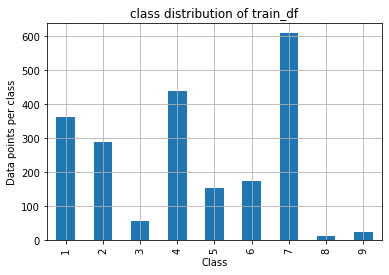

Number of data points in class  7 : 609 ( 28.713 %)
Number of data points in class  4 : 439 ( 20.698 %)
Number of data points in class  1 : 362 ( 17.067 %)
Number of data points in class  2 : 289 ( 13.626 %)
Number of data points in class  6 : 174 ( 8.204 %)
Number of data points in class  5 : 155 ( 7.308 %)
Number of data points in class  3 : 57 ( 2.687 %)
Number of data points in class  9 : 24 ( 1.132 %)
Number of data points in class  8 : 12 ( 0.566 %)


********************************************************************************


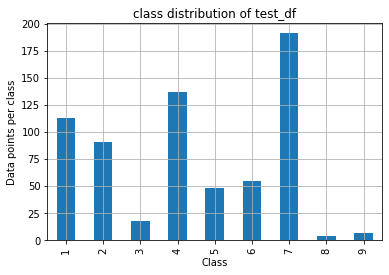

Number of data points in class  7 : 191 ( 28.765 %)
Number of data points in class  4 : 137 ( 20.633 %)
Number of data points in class  1 : 113 ( 17.018 %)
Number of data points in class  2 : 91 ( 13.705 %)
Number of data points in class  6 : 55 ( 8.283 %)
Number of data points in class  5 : 48 ( 7.229 %)
Number of data points in class  3 : 18 ( 2.711 %)
Number of data points in class  9 : 7 ( 1.054 %)
Number of data points in class  8 : 4 ( 0.602 %)


********************************************************************************


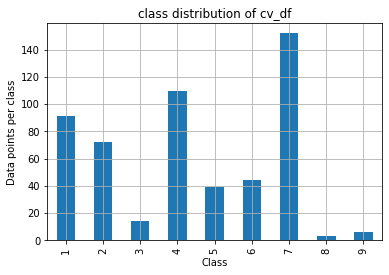

Number of data points in class  7 : 152 ( 28.625 %)
Number of data points in class  4 : 110 ( 20.716 %)
Number of data points in class  1 : 91 ( 17.137 %)
Number of data points in class  2 : 72 ( 13.559 %)
Number of data points in class  6 : 44 ( 8.286 %)
Number of data points in class  5 : 39 ( 7.345 %)
Number of data points in class  3 : 14 ( 2.637 %)
Number of data points in class  9 : 6 ( 1.13 %)
Number of data points in class  8 : 3 ( 0.565 %)


In [17]:
train_class_distribution = train_df['Class'].value_counts().sort_index() # sorting according to index
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()


# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('class distribution of train_df')
plt.grid()
plt.show()

sorted_train_y = np.argsort(-train_class_distribution.values) # return indices to sort the array
for i in sorted_train_y:
    print('Number of data points in class ',i+1, ':',
          train_class_distribution.values[i], '(', np.round(train_class_distribution.values[i]/train_df.shape[0]*100, 3), '%)')

print('\n')
print("*"*80)

my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('class distribution of test_df')
plt.grid()
plt.show()

sorted_test_y = np.argsort(-test_class_distribution.values)
for i in sorted_test_y:
    print('Number of data points in class ',i+1, ':',
          test_class_distribution.values[i], '(', np.round(test_class_distribution.values[i]/test_df.shape[0]*100, 3), '%)')

print('\n')
print("*"*80)

my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('class distribution of cv_df')
plt.grid()
plt.show()

sorted_cv_y = np.argsort(-cv_class_distribution.values)
for i in sorted_cv_y:
    print('Number of data points in class ',i+1, ':',
          cv_class_distribution.values[i], '(', np.round(cv_class_distribution.values[i]/cv_df.shape[0]*100,3), '%)')


In [18]:
# train_class_distribution = train_df['Class'].value_counts().sort_index()
# print(train_class_distribution)
# x = np.argsort(-train_class_distribution.values)
# print(x+1)

# Prediction using a random model

__In random model let's generate the nine class probability that sum to 1__

### Utility function to plot the confusion matrix

In [19]:
def plot_confusionMatrix(test_y, pred_y):

    C = confusion_matrix(test_y, pred_y)
    # this is a 9X9 matrix of 9 class of y_true and predit_y

    A = (((C.T)/C.sum(axis=1)).T) # Recall matrix(predicted true out of total true)

    B = (C/C.sum(axis=0)) # precision matrix(out of predicted true how many are actually true)

    labels = [1,2,3,4,5,6,7,8,9]

    # https://seaborn.pydata.org/generated/seaborn.heatmap.html

    print("-"*30,'Confusion Matrix','-'*30)
    plt.figure(figsize=(12,6))
    sns.heatmap(C, annot=True, cmap='Greens', fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print('\n')
    print("-"*30,'Recall Matrix','-'*30)
    plt.figure(figsize=(12,6))
    sns.heatmap(A, annot=True, cmap='PiYG', fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print('\n')
    print('-'*30,'Precision Matrix', '-'*30)
    plt.figure(figsize=(12,6))
    sns.heatmap(B, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()



Log-loss on Cross-Validation Data using Random Model  2.475706999733867
Log-loss on Tests Data using Random Model  2.5047901102592793
------------------------------ Confusion Matrix ------------------------------


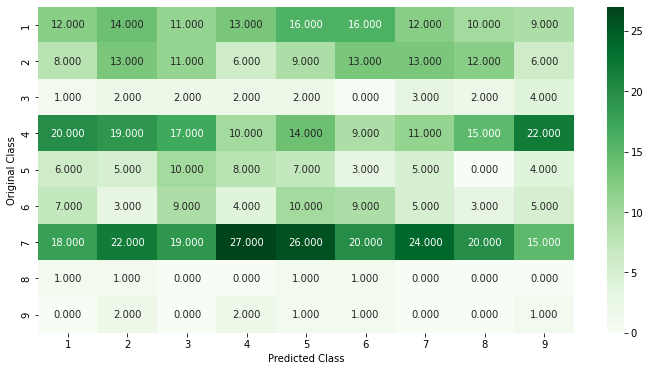



------------------------------ Recall Matrix ------------------------------


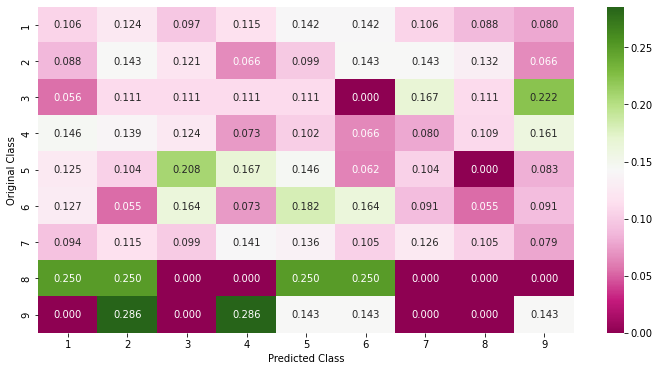



------------------------------ Precision Matrix ------------------------------


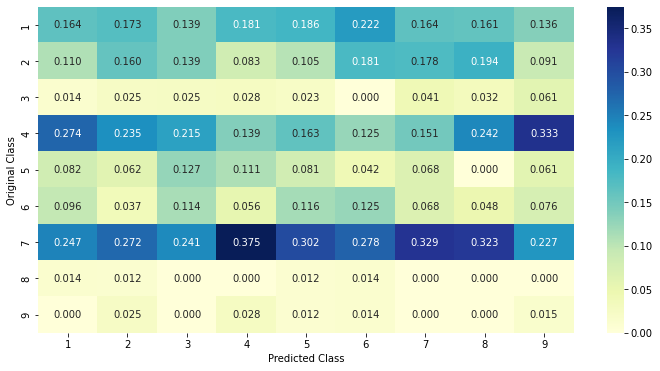

In [20]:
# for building random model we need to generate the nine number
# that sum to 1


test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# create output array of same size as of cv_df
cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log-loss on Cross-Validation Data using Random Model ", log_loss(y_cv, cv_predicted_y,eps=1e-15))

# test-set errors
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_prob = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_prob/sum(sum(rand_prob)))[0])
print("Log-loss on Tests Data using Random Model ", log_loss(y_test, test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusionMatrix(y_test, predicted_y+1)

### Finding the accuracy, Racall and precesion matrix for test case

In [21]:
from sklearn import metrics 
accuracy = metrics.accuracy_score(y_test, predicted_y+1)
precision = metrics.precision_score(y_test, predicted_y+1, average='micro')
recall = metrics.recall_score(y_test, predicted_y+1, average='micro')
print("Accuracy is :", accuracy)
print("Precision is: ", precision)
print("Recall is :", recall)

Accuracy is : 0.11746987951807229
Precision is:  0.11746987951807229
Recall is : 0.11746987951807229


## Univariate Analysis:


In [22]:
# Responce coding algorithm for feature extraction
# Basically we are trying to check the probability of each gene/variation
# in a particular class

# first count the distinct occurance in a feature(gene/variations) this is global count
# then then count the particular gene/variation in each class
# find the probability = (gene/variation in class k+ alpha*10)/global_count_of_gene/variation+ 90*alpha

# here alpha is laplace smoothing to encounter the zero in denominator
# this will represent the vector of size 1X9 as there is 9 class 

# let's code!!

def get_gv_fea_dict(alpha,feature, df):
    #global count of distinct feature-value using train data only
    value_count = train_df[feature].value_counts()

    # make a dict to store array of probability of each gene/variation
    gv_dict = dict()

    for key, value in value_count.items():

        # a vector to store the probability
        vec = []
        for k in range(1,10): # each class iterations

            # count the gene/variation for each class
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==key)]
            
            probability = (cls_cnt.shape[0] +alpha*10)/(value+90*alpha)
            vec.append(probability)

        gv_dict[key] = vec
    
    return gv_dict


# getting the gene/variation features

def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha,feature,df)

    value_count = train_df[feature].value_counts()

    # gene/variation feature: it will contains feature for each value in data
    gv_feature = []

    # now check it is available in the data or not
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_feature.append(gv_dict[row[feature]])
        else:
            gv_feature.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
        
    return gv_feature
    


### when we calculate the probability we often add laplace smoothing to avoid error in dinominator


# Univariate Analysis on Gene Feature

Gene is a categorical variable let's find out how many categories are there and how they are distributed

In [23]:
unique_gene = train_df['Gene'].value_counts()
print("Number of distinct gene are :", unique_gene.shape[0])
print(unique_gene.head(10))

Number of distinct gene are : 234
BRCA1     166
TP53      101
EGFR       93
BRCA2      86
PTEN       73
KIT        66
BRAF       58
ERBB2      47
ALK        45
PDGFRA     41
Name: Gene, dtype: int64


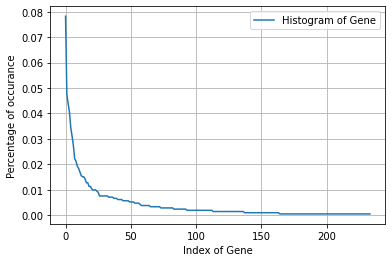

In [24]:
# lets plot the gene distribution to know more about them

s = sum(unique_gene.values)
h = unique_gene.values/s # convert them into 0-1

plt.plot(h, label = "Histogram of Gene")
plt.xlabel("Index of Gene")
plt.ylabel("Percentage of occurance")
plt.legend()
plt.grid()
plt.show()


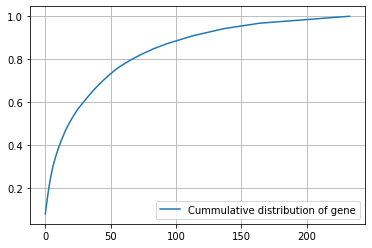

In [25]:
# cummulative distribution

c = np.cumsum(h)
plt.plot(c, label="Cummulative distribution of gene")
plt.grid()
plt.legend()
plt.show()

In [26]:
# around 100 genes are resposible for 90% of total data

## Featurization of Gene and Variations:

1. There is two way to featurize them
*   __Responce coding__
*   __One-Hot encoding__

We will choose the appropriate featurization based on ML model. As we know for logistic/linear Regressor one hot enconding is good however for Random Forest responce-coding is better



In [27]:
# Responce feature of gene-feature
alpha = 1
train_gene_feature_responsecoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene featurization
test_gene_feature_responsecoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cv gene feature
cv_gene_feature_responsecoding = np.array(get_gv_feature(alpha, "Gene", cv_df))


In [28]:
print("train_gene_feature_responsecoding is converted using response coding. The shape of gene feature is :", 
      train_gene_feature_responsecoding.shape)

train_gene_feature_responsecoding is converted using response coding. The shape of gene feature is : (2121, 9)


In [29]:
# One hot encoding 
gene_Vectorizer = CountVectorizer()
train_gene_feature_onehotencoding = gene_Vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotencoding = gene_Vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotencoding = gene_Vectorizer.transform(cv_df['Gene'])


In [30]:
train_df['Gene'].head()

3237    NTRK3
2449    BRCA1
3256    CASP8
1447     SPOP
1141      MET
Name: Gene, dtype: object

In [31]:
# gene_Vectorizer.get_feature_names()
print(train_gene_feature_onehotencoding.shape)
print(train_gene_feature_onehotencoding.toarray())

(2121, 233)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Let's build a machine learning model using each feature (gene and variation) to check how much each contribute to the model

## Since I am using One-Hot encoding I are going to use logistic regressor

In [32]:
# set the parameters for different value
alpha = [10**x for  x in range(-5,2)]
print(alpha)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]


For the value of alpha =  1e-05  The log_loss is : 1.1923823005175502
For the value of alpha =  0.0001  The log_loss is : 1.1557710091679327
For the value of alpha =  0.001  The log_loss is : 1.1961857862135774
For the value of alpha =  0.01  The log_loss is : 1.3187543451590797
For the value of alpha =  0.1  The log_loss is : 1.4337463428253638
For the value of alpha =  1  The log_loss is : 1.4714684101459197
For the value of alpha =  10  The log_loss is : 1.476302354758186


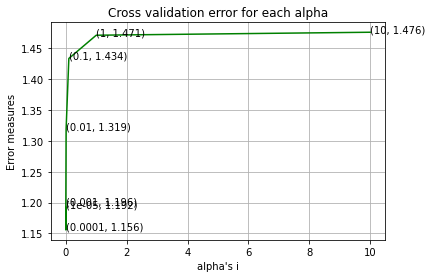

For the value of best alpha =  0.0001 The train log loss is :  0.9820585655386428
For the value of best alpha =  0.0001 The test log loss is :  1.2118227927844782
For the best value of alpha =  0.0001 The cv log loss is  1.1557710091679327


In [33]:
cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l2', loss='log',random_state=42)
    clf.fit(train_gene_feature_onehotencoding, y_train)
    # doing caliberation
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_gene_feature_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotencoding)
    cv_log_loss.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print("For the value of alpha = ", i, " The log_loss is :", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_loss, c='g')
for i, txt in enumerate(np.round(cv_log_loss, 3)): # enumerate to get the indices of losses
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_loss[i]))

plt.grid()
plt.title("Cross validation error for each alpha")
plt.xlabel("alpha's i")
plt.ylabel("Error measures")
plt.show()


# getting value for best alpha

best_alpha_index = np.argmin(cv_log_loss) 
clf = SGDClassifier(alpha = alpha[best_alpha_index], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_feature_onehotencoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotencoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print("For the value of best alpha = ", alpha[best_alpha_index], "The train log loss is : ", train_loss)

predict_y = sig_clf.predict_proba(test_gene_feature_onehotencoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print("For the value of best alpha = ", alpha[best_alpha_index],"The test log loss is : ",test_loss)

predict_y = sig_clf.predict_proba(cv_gene_feature_onehotencoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print("For the best value of alpha = ", alpha[best_alpha_index], "The cv log loss is ", cv_loss)

__Although the test and cv error are quit higher than train error gene feature seems to be stable across all data set. Further Test and CV error are very close to them__

# Univariate Analysis on Variation feature

In [34]:
# this feature is again categorical
# we can either transform them using response coding or one-hot encoding

# get the unique value
unique_variations = train_df['Variation'].value_counts()

print("Number of Unique variations in train data set", unique_variations.shape[0])
print(unique_variations.head(10))


Number of Unique variations in train data set 1927
Truncating_Mutations    62
Deletion                51
Amplification           42
Fusions                 24
Q61R                     3
Overexpression           3
G12C                     2
K117N                    2
G35R                     2
Y42C                     2
Name: Variation, dtype: int64


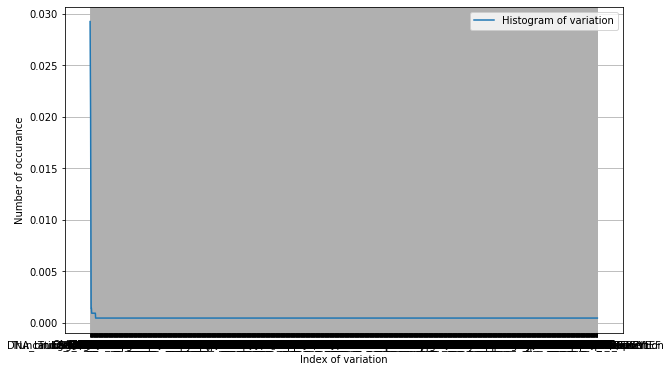

In [35]:
# lets check the distribution of unique_variation feature
s =sum(unique_variations.values)
h = unique_variations/s 

plt.figure(figsize=(10,6))
plt.plot(h, label="Histogram of variation")
plt.xlabel("Index of variation")
plt.ylabel("Number of occurance")
plt.legend()
plt.grid()
plt.show()

Truncating_Mutations    0.029231
Deletion                0.053277
Amplification           0.073079
Fusions                 0.084394
Q61R                    0.085809
                          ...   
Y24C                    0.998114
K129E                   0.998586
R20Q                    0.999057
K641R                   0.999529
G2748D                  1.000000
Name: Variation, Length: 1927, dtype: float64


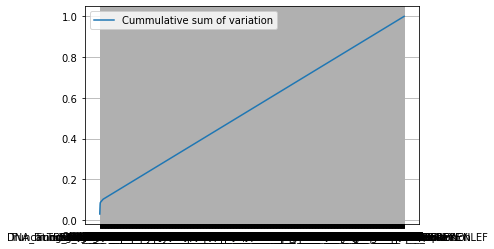

In [36]:
c = np.cumsum(h)
print(c)
plt.plot(c, label="Cummulative sum of variation")
plt.grid()
plt.legend()
plt.show()

In [37]:
# featurizing using response coding
alpha = 1
# train variation
train_variation_feature_responsecoding = np.array(get_gv_feature(alpha, "Variation", train_df))
#test variation
test_variation_feature_responsecoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cv variation
cv_variation_feature_responsecoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [38]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:",
      train_variation_feature_responsecoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2121, 9)


In [39]:
# One-Hot encoding
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotencoding = variation_vectorizer.fit_transform(train_df["Variation"])
test_variation_feature_onehotencoding = variation_vectorizer.transform(test_df["Variation"])
cv_variation_feature_onehotencoding = variation_vectorizer.transform(cv_df["Variation"])


In [40]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:",
      train_variation_feature_onehotencoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2121, 1960)


In [41]:
# BUILDING MODEL JUST LIKE ABOVE
alpha = [10**x for x in range(-5, 1)]
print(alpha)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]


For values of alpha =  1e-05 The log loss is: 1.7164014115094526
For values of alpha =  0.0001 The log loss is: 1.7112719149437126
For values of alpha =  0.001 The log loss is: 1.7212227421788866
For values of alpha =  0.01 The log loss is: 1.7301695560440136
For values of alpha =  0.1 The log loss is: 1.7465966209567463
For values of alpha =  1 The log loss is: 1.7485345972766138


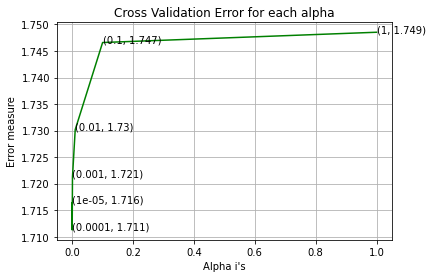

For the value of best alpha =  0.0001 The train loss is  0.6126078896987406
For the value of best alpha =  0.0001 The test loss is  1.7134959332039121
For the best value of alpha =  0.0001 The cv loss is  1.7112719149437126


In [42]:
# building a logistic regressor

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotencoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotencoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# get the best alpha and check test and cv error
best_alpha_index = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha_index], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotencoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_feature_onehotencoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotencoding)
train_loss = log_loss(y_train, predict_y)
print("For the value of best alpha = ", alpha[best_alpha_index], "The train loss is ", train_loss)

predict_y = sig_clf.predict_proba(test_variation_feature_onehotencoding)
test_loss = log_loss(y_test, predict_y)
print("For the value of best alpha = ", alpha[best_alpha_index], "The test loss is ", test_loss)

predict_y = sig_clf.predict_proba(cv_variation_feature_onehotencoding)
cv_loss = log_loss(y_cv, predict_y)
print("For the best value of alpha = ", alpha[best_alpha_index], "The cv loss is ", cv_loss)

__Variation feature is not stable as much as gene feature as we can see from the above result. CV/test loss is almost three time more than train loss__

In [43]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1927  genes in test and cross validation data sets?
Ans
1. In test data 72 out of 664 : 10.843373493975903
2. In cross validation data 52 out of  531 : 9.792843691148775


# Univariate Analysis on Text feature (clinical literature):


### Training Logistic Regression+Calibration on one-hot-encoding text features

In [44]:
# creating a dictionary of each class and maintain a list of it.

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [45]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [46]:
print(train_df.shape)

(2121, 5)


In [47]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))


Total number of unique words in train data : 54211


In [48]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [49]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [50]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [51]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [52]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5671, 4: 3652, 6: 3115, 5: 2712, 8: 2191, 9: 1941, 7: 1825, 10: 1344, 12: 1290, 11: 1235, 15: 939, 18: 927, 13: 899, 16: 860, 14: 816, 20: 654, 22: 565, 24: 558, 17: 541, 19: 535, 21: 487, 23: 434, 25: 406, 42: 374, 26: 367, 28: 359, 27: 355, 30: 350, 36: 285, 33: 282, 32: 279, 50: 275, 37: 255, 31: 255, 40: 251, 35: 244, 29: 242, 34: 229, 39: 211, 38: 203, 44: 197, 45: 186, 46: 183, 43: 183, 52: 175, 41: 172, 48: 169, 57: 152, 51: 147, 55: 144, 47: 143, 56: 141, 49: 141, 60: 137, 54: 133, 66: 130, 53: 129, 63: 124, 58: 119, 65: 118, 59: 117, 74: 108, 61: 107, 62: 105, 68: 104, 72: 99, 64: 99, 69: 98, 67: 93, 78: 90, 77: 90, 70: 84, 84: 82, 75: 81, 80: 80, 73: 79, 85: 78, 95: 77, 86: 77, 76: 77, 100: 76, 81: 75, 83: 72, 89: 71, 71: 71, 94: 70, 82: 69, 79: 67, 92: 65, 87: 65, 91: 63, 102: 62, 93: 59, 105: 58, 111: 57, 97: 57, 96: 57, 120: 56, 88: 56, 90: 55, 114: 53, 108: 53, 127: 52, 115: 52, 99: 52, 110: 48, 104: 48, 101: 48, 98: 48, 109: 47, 140: 46, 123: 46, 122: 46, 117

For values of alpha =  1e-05 The log loss is: 1.2753624702079098
For values of alpha =  0.0001 The log loss is: 1.1556330594353779
For values of alpha =  0.001 The log loss is: 1.124068604791829
For values of alpha =  0.01 The log loss is: 1.2041534141593695
For values of alpha =  0.1 The log loss is: 1.4297396166522767
For values of alpha =  1 The log loss is: 1.6469169458515804


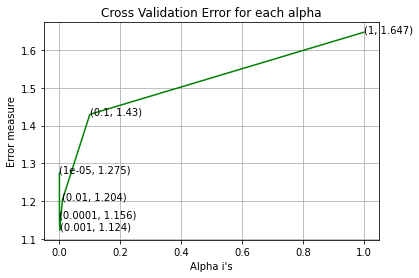

In [53]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [54]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
losses = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",losses)
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
losses = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",losses)
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
losses = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",losses)

For values of best alpha =  0.001 The train log loss is: 0.6429124141358653
For values of best alpha =  0.001 The cross validation log loss is: 1.124068604791829
For values of best alpha =  0.001 The test log loss is: 1.2533576947940135


_Text Feature looks stable across all the data set, however train error is almost half of test and cross-validation but the test and validation error look similar_

In [55]:
#get intersect text

def get_intersect_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features), df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1, len2

In [56]:
len1, len2 = get_intersect_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word test data appeared in train data")

len1, len2 = get_intersect_text(cv_df)
print(np.round((len2/len1)*100), "% of word cross validation appeared in train data")

96.654 % of word test data appeared in train data
99.0 % of word cross validation appeared in train data


# Machine Learning Model

In [57]:
# data preprocessing and misc functions for machine learning model

def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(clf,train_x, train_y)

    pred_y = sig_clf.predict(test_x)

    # for calculating log-loss we will provide array of probablities belonging to each class
    predicted_y = sig_clf.predit_proba(test_x)
    losses = log_loss(test_y, predicted_y)
    print("Log loss is ", losses)

    # calculating the missclassified data 
    miss_classified = np.count_nonzeros((pred_y-test_y))/test_y.shape[0]
    print("Number of miss classified data points are ", miss_classified)
    plot_confusionMatrix(test_y, pred_y)


In [58]:
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x, train_y)
    sig_clf_prob = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_prob, eps=1e15)

In [79]:
# In case of naive bayes we will check if feature is present or not
# get the importance feature names
def get_impfeature_names(indices,text, gen, var, no_features):
    gen_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gen_vec = gen_count_vec.fit(train_df['Gene'])
    var_vec = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])

    fea1_len = len(gen_vec.get_feature_names())
    fea2_len = len(var_vec.get_feature_names())

    word_present = 0

    for i, v in enumerate(indices):
        if(v < fea1_len):
            word = gen_vec.get_feature_names()[v]
            yes_no = True if word == gen else False 
            if yes_no:
                word_present+=1
                print(i, "Gene feature [{}] present in the test data point [{}]". format(word, yes_no))

        elif(v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present+=1 
                print(i, "Variation feature [{}] present in the test data point [{}] ".format(word, yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False 
            if yes_no:
                word_present+=1 
                print(i, "Text feature [{}] present in test data point [{}] ". format(word, yes_no))

    print("Out of the top", no_features,"features ", word_present, "are present in the query points")

## Stacking the three types of features

---



---



In [60]:
# merging gene, variance and text features
# Verticle stacking requires equal no of rows and it increases the no of features(columns)
# Horizontal Stacking requires equal no of columns and it increases the no of data points(rows)
# building train, test, and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

##############ONEHOTENCODING##################

train_gene_var_onehotencoding = hstack((train_gene_feature_onehotencoding,train_variation_feature_onehotencoding))
test_gene_var_onehotencoding = hstack((test_gene_feature_onehotencoding,test_variation_feature_onehotencoding))
cv_gene_var_onehotencoding = hstack((cv_gene_feature_onehotencoding,cv_variation_feature_onehotencoding))

train_x_onehotencoding = hstack((train_gene_var_onehotencoding, train_text_feature_onehotCoding)).toarray()
train_y = np.array(list(train_df['Class']))

test_x_onehotencoding = hstack((test_gene_var_onehotencoding, test_text_feature_onehotCoding)).toarray()
test_y = np.array(list(test_df['Class']))

cv_x_onehotencoding = hstack((cv_gene_var_onehotencoding, cv_text_feature_onehotCoding)).toarray()
cv_y = np.array(list(cv_df['Class']))

In [61]:
print("One Hot Encoding features...")
print("(Number of data points * Number of features in train dataset is )", train_x_onehotencoding.shape)
print("(Number of data points * Number of features in test dataset is )", test_x_onehotencoding.shape)
print("(Number of data points * Number of feature in cross validation is )", cv_x_onehotencoding.shape)

One Hot Encoding features...
(Number of data points * Number of features in train dataset is ) (2121, 56404)
(Number of data points * Number of features in test dataset is ) (664, 56404)
(Number of data points * Number of feature in cross validation is ) (531, 56404)


In [62]:
train_gene_var_responsecoding = np.hstack((train_gene_feature_responsecoding, train_variation_feature_responsecoding))
test_gene_var_responsecoding = np.hstack((test_gene_feature_responsecoding,test_variation_feature_responsecoding))
cv_gene_var_responsecoding = np.hstack((cv_gene_feature_responsecoding,cv_variation_feature_responsecoding))

train_x_responsecoding = np.hstack((train_gene_var_responsecoding,train_text_feature_responseCoding))
test_x_responsecoding = np.hstack((test_gene_var_responsecoding,test_text_feature_responseCoding))
cv_x_responsecoding = np.hstack((cv_gene_var_responsecoding, cv_text_feature_responseCoding))

In [63]:
print("Response Encoded features ...")
print("Number of data points and features in train dataset is ", train_x_responsecoding.shape)
print("Number of data points and features in test datsset is ", test_x_responsecoding.shape)
print("Number of data points and features in cross validation is ", cv_x_responsecoding.shape)

Response Encoded features ...
Number of data points and features in train dataset is  (2121, 27)
Number of data points and features in test datsset is  (664, 27)
Number of data points and features in cross validation is  (531, 27)


## Base Line Models

## Model : 1 Naive Bayes 

for alpha = 1e-05
Log Loss : 1.2282592409113668
for alpha = 0.0001
Log Loss : 1.2221977552609462
for alpha = 0.001
Log Loss : 1.2155163609322472
for alpha = 0.1
Log Loss : 1.202751930100132
for alpha = 1
Log Loss : 1.2172411956635067
for alpha = 10
Log Loss : 1.3549904130963357
for alpha = 100
Log Loss : 1.340706810224352
for alpha = 1000
Log Loss : 1.3226223166616624


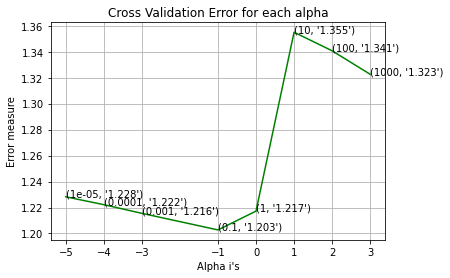

In [64]:
# more about Multinomial Naive bayes http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# more about CalibratedClassifierCV at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotencoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotencoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotencoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [65]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotencoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.8350419374817204
For values of best alpha =  0.1 The cross validation log loss is: 1.202751930100132
For values of best alpha =  0.1 The test log loss is: 1.3226984674219808


### Testing the model with best hyperparameter

log loss is  1.202751930100132
Number of miss classified points are  0.35969868173258
------------------------------ Confusion Matrix ------------------------------


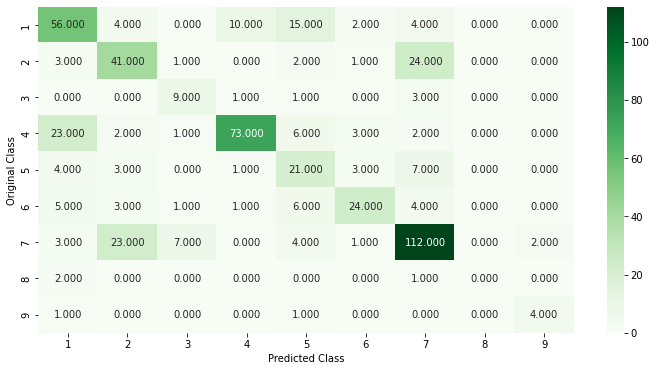



------------------------------ Recall Matrix ------------------------------


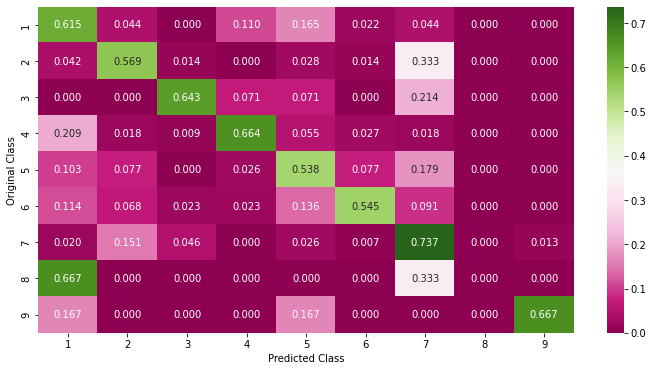



------------------------------ Precision Matrix ------------------------------


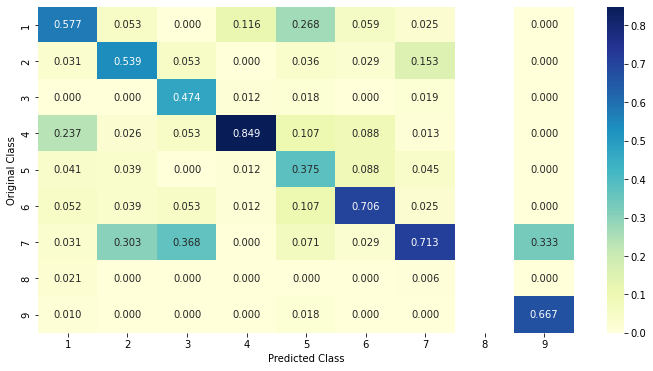

In [66]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotencoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotencoding)
print("log loss is ", log_loss(cv_y, sig_clf_probs))
print("Number of miss classified points are ", np.count_nonzero(sig_clf.predict(cv_x_onehotencoding)-cv_y)/cv_y.shape[0])
plot_confusionMatrix(cv_y, sig_clf.predict(cv_x_onehotencoding))

## Feature Importance and Correctly classified points

In [67]:
test_point_index = 1
no_features = 100
predict_cls = sig_clf.predict(test_x_onehotencoding[test_point_index].reshape(1,-1))
print("Predicted Class is : ", predict_cls[0])
predict_prob_cls = sig_clf.predict_proba(test_x_onehotencoding[test_point_index].reshape(1,-1))
print("Predicted Class probablity is :", np.round(predict_prob_cls[0], 4))
print("Actuall Class is :", test_y[0])


Predicted Class is :  5
Predicted Class probablity is : [0.1044 0.0961 0.0179 0.1511 0.4228 0.0424 0.1552 0.0058 0.0042]
Actuall Class is : 7


In [80]:
print(predict_cls)

[2]


In [68]:
indices = np.argsort(-1*clf.coef_)[predict_cls-1][:,:no_features]
t = test_df['TEXT'].iloc[test_point_index]
g = test_df['Gene'].iloc[test_point_index]
v = test_df['Variation'].iloc[test_point_index]
get_impfeature_names(indices[0],t,g,v, no_features)

6 Text feature [cooccurrence] present in test data point [True] 
7 Text feature [neutral] present in test data point [True] 
9 Text feature [assays] present in test data point [True] 
10 Text feature [functional] present in test data point [True] 
11 Text feature [align] present in test data point [True] 
12 Text feature [variants] present in test data point [True] 
13 Text feature [gvgd] present in test data point [True] 
16 Text feature [uncertain] present in test data point [True] 
17 Text feature [nhgri] present in test data point [True] 
18 Text feature [evolutionarily] present in test data point [True] 
19 Text feature [v1736a] present in test data point [True] 
21 Text feature [r1699q] present in test data point [True] 
22 Text feature [agvgd] present in test data point [True] 
23 Text feature [article] present in test data point [True] 
24 Text feature [classifying] present in test data point [True] 
25 Text feature [usefulness] present in test data point [True] 
Out of the top

In [69]:
print(t)

abstract brca1 gene individuals risk breast ovarian cancers screened presence mutations however cancer association alleles carrying missense mutations unknown thus creating significant problems genetic counseling increase ability identify cancer associated mutations brca1 set use principles protein three dimensional structure well correlation cancer associated mutations abolish transcriptional activation thirty one 37 missense mutations known impact transcriptional activation function brca1 readily rationalized structural terms loss function mutations involve nonconservative changes core brca1 c terminus brct fold localized groove presumably forms binding site involved transcriptional activation brca1 mutations abolish transcriptional activation either conservative changes core surface outside putative binding site next structure based rules predicting functional consequences given missense mutation applied 57 germ line brca1 variants unknown cancer association structure based approach

In [70]:
print(g)
print(v)

BRCA1
G1788D


In [71]:
print(clf.coef_.shape)

(9, 56404)


In [89]:
# picking 10 most important features based on their weights(coef_)
print(np.argsort(-1*clf.coef_)[predict_cls-1][:,:10])
print(indices[0]) # this is 1D array of weights(coef_) 

[[112  58 758  25   0 332  99  64 159 193]]
[   26    27    85   160   100   188 16652 37185 54907 10966 24006  9396
 54440 26085    25    64 53428 37283 22053 54038 44147 43785  9139 10707
 15499 53910 46583 36452 45904 38157  6134 43170  4352  4740  6132 34188
  5216  6135  6113  4807 16227 53438  6070 28913  6021 35242  6142 47308
 54830 34293  6285  6282 46417 12756 46418  6275  6274  6272  6270 30566
 46435 46436  2923  2924 50017 33405  4398 12881 12882  4829 20474  5954
 13319  5594  5581  5556  5538  5513 56071 39123  5430 13406  5389 28581
  5379 13597  4720  5016  5312 26634  3244  5607  5965  5608 26178 37043
  5945 51869 28376  5908]


In [72]:
print(indices[0])

[   26    27    85   160   100   188 16652 37185 54907 10966 24006  9396
 54440 26085    25    64 53428 37283 22053 54038 44147 43785  9139 10707
 15499 53910 46583 36452 45904 38157  6134 43170  4352  4740  6132 34188
  5216  6135  6113  4807 16227 53438  6070 28913  6021 35242  6142 47308
 54830 34293  6285  6282 46417 12756 46418  6275  6274  6272  6270 30566
 46435 46436  2923  2924 50017 33405  4398 12881 12882  4829 20474  5954
 13319  5594  5581  5556  5538  5513 56071 39123  5430 13406  5389 28581
  5379 13597  4720  5016  5312 26634  3244  5607  5965  5608 26178 37043
  5945 51869 28376  5908]


In [73]:
for i in range(10,21):
    test_point_index = i
    no_features = 100
    predict_cls = sig_clf.predict(test_x_onehotencoding[test_point_index].reshape(1,-1))
    print("Predicted Class is : ", predict_cls[0])
    predict_prob_cls = sig_clf.predict_proba(test_x_onehotencoding[test_point_index].reshape(1,-1))
    print("Predicted Class probablity is :", np.round(predict_prob_cls[0], 4))
    print("Actuall Class is :", test_y[0])
    print("*"*100)


Predicted Class is :  7
Predicted Class probablity is : [0.0754 0.0702 0.013  0.11   0.0341 0.0308 0.6591 0.0043 0.003 ]
Actuall Class is : 7
****************************************************************************************************
Predicted Class is :  1
Predicted Class probablity is : [0.3773 0.0881 0.0165 0.1395 0.1847 0.0402 0.1444 0.0054 0.004 ]
Actuall Class is : 7
****************************************************************************************************
Predicted Class is :  2
Predicted Class probablity is : [0.0886 0.3745 0.0154 0.1293 0.0939 0.035  0.2548 0.0051 0.0034]
Actuall Class is : 7
****************************************************************************************************
Predicted Class is :  4
Predicted Class probablity is : [0.0708 0.0655 0.0124 0.6783 0.0319 0.0287 0.1055 0.004  0.0029]
Actuall Class is : 7
****************************************************************************************************
Predicted Class is :  6
Pred